In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import folium
from folium.plugins import FloatImage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [64]:
listings = pd.read_csv('../input/airbnb/listings.csv')
calendar = pd.read_csv('../input/airbnb/calendar.csv')
reviews = pd.read_csv('../input/airbnb/reviews.csv')

In [65]:
calendar.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,257163,2019-09-17,f,$65.00,$65.00,3,14
1,257163,2019-09-18,f,$65.00,$65.00,3,14
2,5731,2019-09-17,f,$40.00,$40.00,2,30
3,5731,2019-09-18,f,$40.00,$40.00,2,30
4,5731,2019-09-19,f,$40.00,$40.00,2,30


In [66]:
listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5731,https://www.airbnb.com/rooms/5731,20190917034805,2019-09-17,Mai Lodging - Room Single bed 5,The rental area has been remodeled as of April...,"Located right next to a beautiful open park, K...",The rental area has been remodeled as of April...,none,NaN,NaN,NEARBY BUSES #20 to Downtown & Broadway Skytra...,NaN,NaN,Check in & Check Out Checking in will be 1:00 ...,NaN,NaN,https://a0.muscache.com/im/pictures/20897/ecc5...,NaN,9187,https://www.airbnb.com/users/show/9187,Mai,2009-03-05,"Vancouver, British Columbia, Canada",Hello! We are Mai and Tan. We have been reside...,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/9187/profile_...,https://a0.muscache.com/im/users/9187/profile_...,Kensington-Cedar Cottage,7.0,7.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Vancouver, BC, Canada",Kensington-Cedar Cottage,Kensington-Cedar Cottage,NaN,Vancouver,BC,V5N 4H8,Vancouver,"Vancouver, Canada",CA,Canada,49.24788,-123.06537,...,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",0.0,$38.00,NaN,NaN,$0.00,$40.00,1,$0.00,2,30,2,2,30,30,2.0,30.0,a week ago,t,20,41,71,346,2019-09-17,103,10,2009-04-19,2019-08-19,90.0,9.0,9.0,10.0,9.0,9.0,9.0,t,19-249323,"{""British Columbia"","" Canada"","" Vancouver"","" B...",t,f,strict_14_with_grace_period,f,f,6,2,4,0,0.81
1,10080,https://www.airbnb.com/rooms/10080,20190917034805,2019-09-17,D1 - Million Dollar View 2 BR,"Stunning two bedroom, two bathroom apartment. ...","Bed setup: 2 x queen, option to add up to 2 tw...","Stunning two bedroom, two bathroom apartment. ...",none,NaN,1. CHECK-IN TIME IS AFTER 3PM PST AND CHECK-OU...,NaN,"Enjoy our amenities which include gym, pool, h...",NaN,1. CHECK-IN TIME IS AFTER 3 PM PST AND CHECK-O...,NaN,NaN,https://a0.muscache.com/im/pictures/55778229/c...,NaN,30899,https://www.airbnb.com/users/show/30899,Rami,2009-08-10,"Vancouver, British Columbia, Canada",I will be happy to host you.,within an hour,90%,NaN,f,https://a0.muscache.com/im/pictures/user/55302...,https://a0.muscache.com/im/pictures/user/55302...,Coal Harbour,41.0,41.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Vancouver, BC, Canada",Coal Harbour,Downtown,NaN,Vancouver,BC,V6E 2P4,Vancouver,"Vancouver, Canada",CA,Canada,49.28772,-123.12110,...,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1200.0

### Reviews

In [67]:

reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,5731,1609,2009-04-19,11052,Carmen,This was just perfect for a professional visit...
1,5731,1919,2009-04-30,11973,Meseret,Mai Lodging is very clean and fully furnished....
2,5731,3963,2009-06-13,18827,Rob,"Very nice place, and good location for getting..."
3,5731,3967,2009-06-13,18888,Armin,Awesome place! Best price! It's just really ni...
4,5731,5186,2009-07-07,17965,Michel,Great food right in the neighbourhood (vietnam...


In [68]:
calendar['available'] = calendar.available.map(lambda x: 1 if x == 't' else 0)

In [69]:
calendar.date = pd.to_datetime(calendar.date)

In [70]:
calendar['price'] = calendar['price'].str.replace('$', '').str.replace(',', '')
calendar['price'] = calendar['price'].astype(float)

In [71]:
calendar_365 = calendar.groupby(
    'date')['available', 'price'].mean().reset_index()
calendar_365.rename(
    columns={'price': 'average_price', 'available': 'vacancy'}, inplace=True)
calendar_365['occupancy'] = (1 - calendar_365['vacancy']) * 100
calendar_365['dayofweek'] = calendar_365.date.dt.weekday_name.str[:3]
calendar_365['month'] = calendar_365.date.dt.month_name().str[:3]

In [72]:
def plot_calendar(groupby_col, agg_col):
    df_index = list(calendar_365[groupby_col].unique())
    grouped_df = calendar_365.groupby(
        groupby_col)[agg_col].mean().reindex(df_index)

    plt.plot(grouped_df)
    plt.ylabel(agg_col.replace('_', ' ').title())
    plt.title(" {} by {}".format(agg_col.replace('_', ' ').title(),
                                 groupby_col.title()), fontsize=18, fontweight='bold')
    ticks = list(range(len(df_index)))
    labels = df_index
    plt.xticks(ticks, labels)
    plt.show()

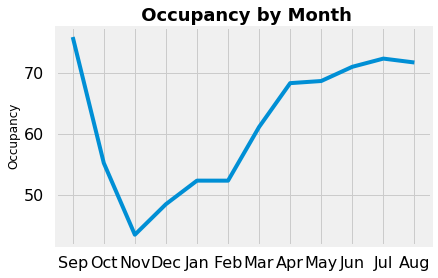

In [73]:
plot_calendar('month', 'occupancy')

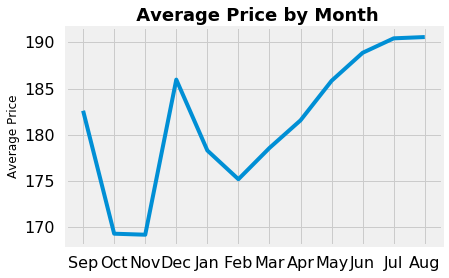

In [74]:
plot_calendar('month', 'average_price')

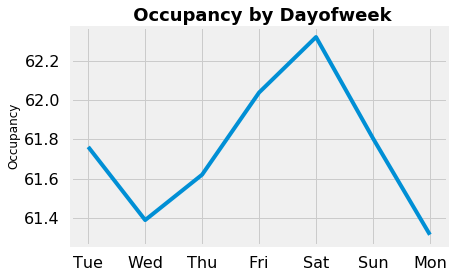

In [75]:
plot_calendar('dayofweek', 'occupancy')

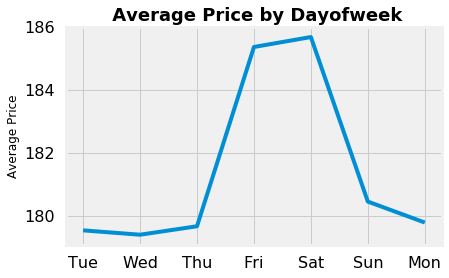

In [76]:
plot_calendar('dayofweek', 'average_price')

In [77]:
listings.price = listings.price.str.replace('$', '').str.replace(',', '')
listings['price'] = listings['price'].astype(float)

Text(0.5, 1.0, 'Boxplot for listings.price.')

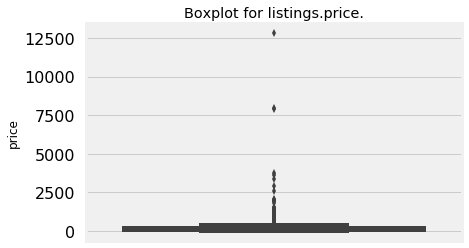

In [78]:
sns.boxplot(listings.price, orient='v').set_title(
    'Boxplot for listings.price.')

In [79]:
listings['price'].describe()

count     6176.000000
mean       181.872733
std        278.160859
min         15.000000
25%         87.000000
50%        130.000000
75%        200.000000
max      12800.000000
Name: price, dtype: float64

In [80]:
def group_plot(df, groupby_col, agg_col, plot_type, top_k=10):
    if plot_type == 'count':

        if agg_col == 'id':
            grouped_df = df.groupby(groupby_col)[agg_col].count()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df,
                                  palette="Set1", order=order_index)

            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Listings count')
            plt.title('Top neighborhoods based on listing counts',
                      fontsize=18, fontweight='bold')

        elif agg_col == 'price_bins':
            bins = [0, 101, 201, 301, 401, 501, 1000]
            group = ['1-100', '101-200', '201-300',
                     '301-400', '400-500', '500+']

            df['price_bins'] = pd.cut(df['price'], bins, labels=group)

            grouped_df = df.groupby(groupby_col)['price'].median()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df, hue='price_bins',
                                  orient='h', palette="Set1", order=order_index)
            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Price bins count')
            plt.title('Top neighborhoods price distribution',
                      fontsize=18, fontweight='bold')
            plt.legend(loc='upper right')

    elif plot_type == 'box':
        grouped_df = df.groupby(groupby_col)[agg_col].median()
        order_index = grouped_df.sort_values(ascending=False).index[:top_k]
        sns.boxplot(x=groupby_col, y=agg_col, data=df,
                    palette="Set1", order=order_index)

        plt.xlabel('Neighborhood')
        plt.ylabel('Price')
        plt.title('Top neighborhoods based on listing prices',
                  fontsize=18, fontweight='bold')

    plt.xticks(
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large'
    )

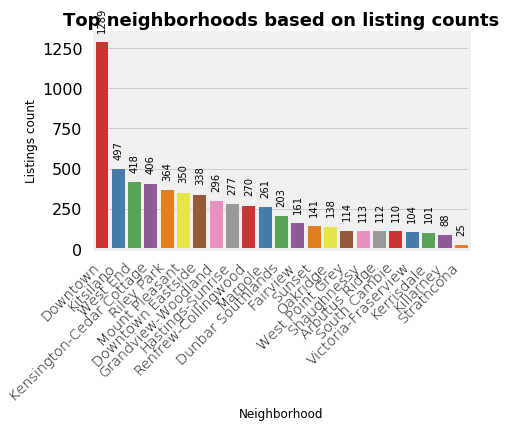

In [81]:
group_plot(listings, 'neighbourhood_cleansed', 'id', 'count', 25)

In [82]:
def plot_top_neighborhood_locations(df, groupby_col):
    latitude = 49.2827
    longitude = -123.1207

    color_list = ['red', 'blue', 'gray', 'darkred', 'lightgreen',
                  'orange', 'black', 'cadetblue', 'darkgreen', 'purple']

    grouped_df = df.groupby(groupby_col)['id'].count()
    top_nbrhd_list = list(grouped_df.sort_values(ascending=False).index[:10])
    top_nbrhd = listings[listings[groupby_col].isin(top_nbrhd_list)]
    colormap = dict(zip(top_nbrhd_list, color_list))
    vancouver_map = folium.Map(location=[latitude, longitude], zoom_start=12)
    incidents = folium.map.FeatureGroup()

    for lat, lng, nbrhd in zip(top_nbrhd.latitude, top_nbrhd.longitude, top_nbrhd[groupby_col]):
        if nbrhd in colormap:
            nbrhd_color = colormap[nbrhd]
            incidents.add_child(
                folium.vector_layers.CircleMarker(
                    [lat, lng],
                    radius=1.0, 
                    color=nbrhd_color,
                    fill=False,
                    popup=nbrhd,
                    fill_color='blue',
                    fill_opacity=0.05
                )
            )
    vancouver_map.add_child(incidents)

    folium.plugins.FloatImage(image_file, bottom=55,
                              left=70).add_to(vancouver_map)

    return vancouver_map

In [84]:
plot_top_neighborhood_locations(listings, 'neighbourhood_group_cleansed')

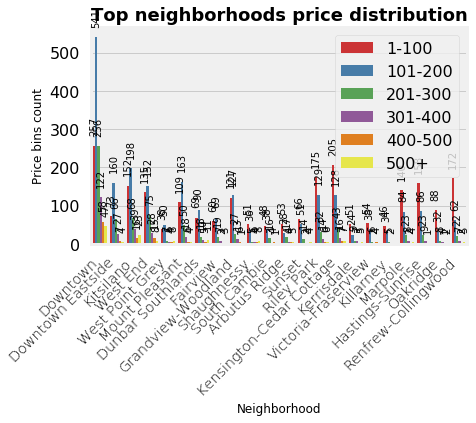

In [87]:
group_plot(top_nbrhd, 'neighbourhood_cleansed', 'price_bins', 'count', 25)

Text(0.5, 1.0, 'Price vs Number of Reviews')

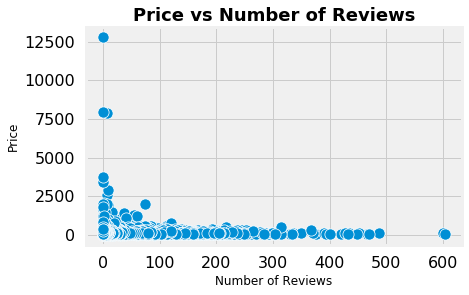

In [88]:
sns.scatterplot(x=listings['number_of_reviews'], y=listings['price'])
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Price vs Number of Reviews', fontsize=18, fontweight='bold')

In [89]:
def plot_price_vs_popularity(df, top_k):
    x = df.groupby('neighbourhood_cleansed')[
        'number_of_reviews'].mean().sort_index()[:top_k]
    y = df.groupby('neighbourhood_cleansed')[
        'price'].mean().sort_index()[:top_k]
    n = (x.reset_index()).neighbourhood_cleansed.tolist()[:top_k]
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.scatter(x, y, c=y, cmap=sns.diverging_palette(
        220, 20, sep=20, as_cmap=True), s=200)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), fontsize=12)

    plt.xlabel('Average Number of Reviews')
    plt.ylabel('Average Price')
    plt.title('Average Price and Popularity of Listings',
              fontsize=18, fontweight='bold')

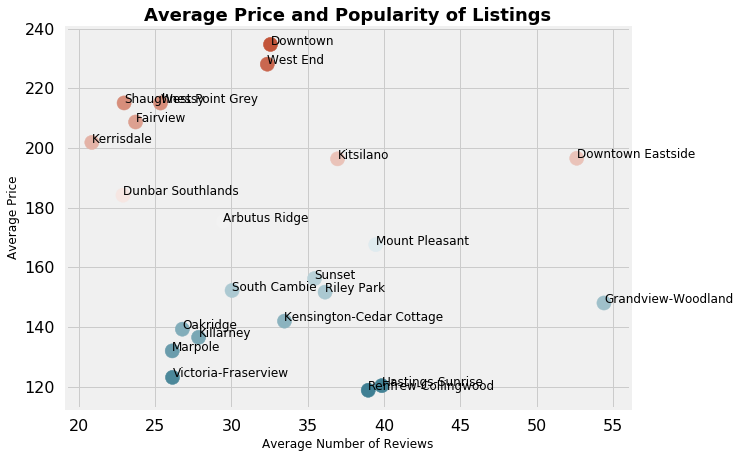

In [90]:
plot_price_vs_popularity(top_nbrhd, 25)

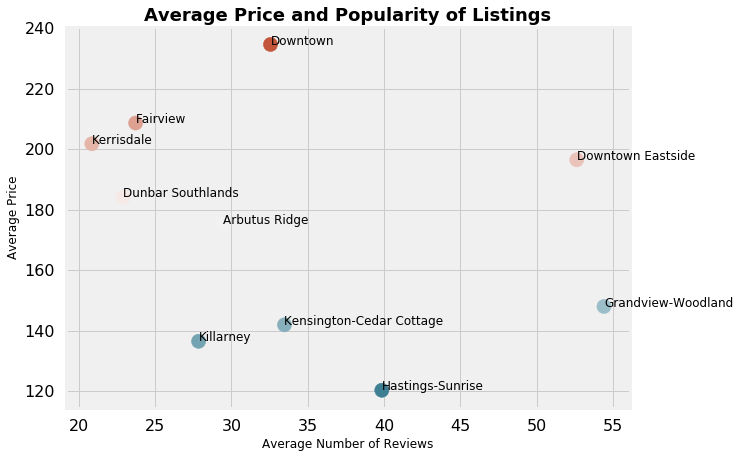

In [91]:
plot_price_vs_popularity(top_nbrhd, 10)

In [92]:
features = ['cancellation_policy', 'is_location_exact', 'accommodates', 'reviews_per_month', 'property_type', 'price',
            'host_total_listings_count', 'extra_people', 'calculated_host_listings_count', 'guests_included',
            'review_scores_rating', 'host_response_time', 'number_of_reviews', 'host_is_superhost', 'room_type',
            'instant_bookable', 'amenities', 'host_identity_verified', 'host_has_profile_pic', 'security_deposit',
            'host_listings_count', 'requires_license', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed',
            'minimum_nights', 'bathrooms', 'require_guest_phone_verification', 'cleaning_fee']

In [93]:
data = listings[features].copy()

In [94]:
data.cleaning_fee = data.cleaning_fee.str.replace('$', '').str.replace(',', '')
data.cleaning_fee = data.cleaning_fee.astype(float)

data.security_deposit = data.security_deposit.str.replace(
    '$', '').str.replace(',', '')
data.security_deposit = data.security_deposit.astype(float)

data.extra_people = data.extra_people.str.replace('$', '').str.replace(',', '')
data.extra_people = data.extra_people.astype(float)

In [98]:
num_cols = data_clean.select_dtypes(exclude='object').columns
cat_cols = data_clean.select_dtypes(include='object').columns
data_clean[cat_cols] = data_clean[cat_cols].apply(
    lambda col: col.fillna(col.mode()[0]))
data_clean[num_cols] = data_clean[num_cols].apply(
    lambda col: col.fillna(col.median()))

In [99]:
data_clean['number_of_amenities'] = data_clean['amenities'].apply(
    lambda x: len(x.replace('{', '').replace('}', '').split(',')))

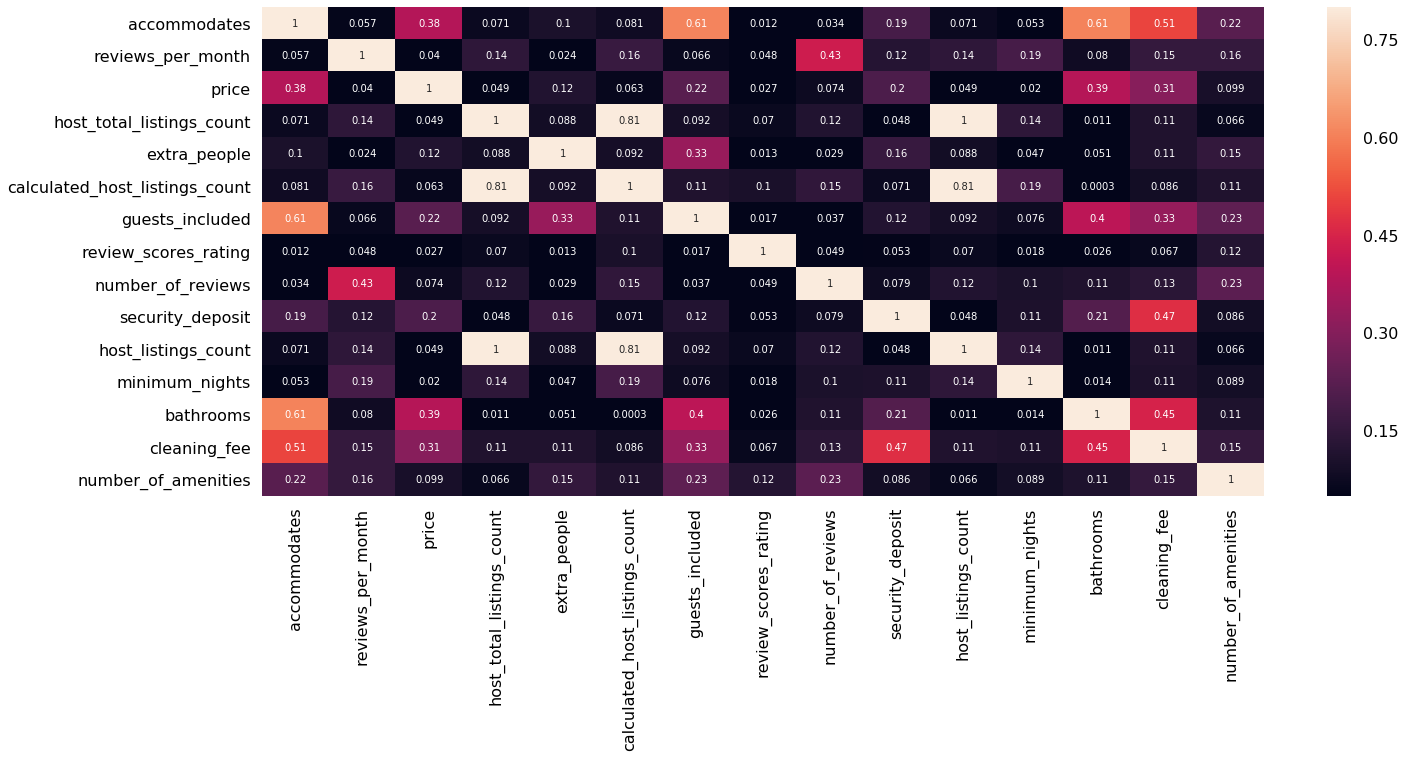

In [103]:
corr_matrix = data_clean.corr()
corr_matrix = abs(corr_matrix)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True)

In [104]:
corr_matrix['price'].sort_values(ascending=False)

price                             1.000000
bathrooms                         0.386817
accommodates                      0.383590
cleaning_fee                      0.307728
guests_included                   0.221775
security_deposit                  0.200660
extra_people                      0.115948
number_of_amenities               0.099326
number_of_reviews                 0.074313
calculated_host_listings_count    0.062880
host_listings_count               0.048947
host_total_listings_count         0.048947
reviews_per_month                 0.040060
review_scores_rating              0.026811
minimum_nights                    0.020269
Name: price, dtype: float64

In [105]:
def select_cat_features(df, cols_list, unique_thres=15):
    selected_features = []
    for col in cols_list:
        if len(df[col].unique()) <= unique_thres:
            selected_features.append(col)

    return selected_features

In [106]:
def select_features(df, unique_thres=15, corr_thres=0.4):
    num_cols = df.select_dtypes(exclude='object').columns
    corr = df[num_cols].corr()
    corr_matrix = corr.abs()
    selected_num_features = corr_matrix[(
        corr_matrix['price'] > corr_thres)]['price'].index.tolist()

    cat_cols = df.select_dtypes(include='object').columns
    selected_cat_features = select_cat_features(df, cat_cols, unique_thres)
    selected_features = selected_num_features + selected_cat_features
    return selected_features, selected_num_features, selected_cat_features

In [107]:
selected_cols, num_cols, cat_cols = select_features(data_clean, 20, 0)

In [108]:
print("Selected numerical features are:", str(num_cols)[1:-1])

Selected numerical features are: 'accommodates', 'reviews_per_month', 'price', 'host_total_listings_count', 'extra_people', 'calculated_host_listings_count', 'guests_included', 'review_scores_rating', 'number_of_reviews', 'security_deposit', 'host_listings_count', 'minimum_nights', 'bathrooms', 'cleaning_fee', 'number_of_amenities'


In [109]:
print("Selected categorical features are:", str(cat_cols)[1:-1])

Selected categorical features are: 'cancellation_policy', 'is_location_exact', 'host_response_time', 'host_is_superhost', 'room_type', 'instant_bookable', 'host_identity_verified'


In [110]:
def transform_data(df, num_cols, cat_cols):
    transformed_df = df.copy()

    for col in cat_cols:
        transformed_df[col] = transformed_df[col].astype('category')
        transformed_df = pd.concat([transformed_df.drop(
            col, axis=1), pd.get_dummies(transformed_df[col], prefix=col)], axis=1)
    transformed_df[num_cols] = transformed_df[num_cols].apply(
        lambda x: np.log(x+1))

    num_cols.remove('price')
    scaler = MinMaxScaler()
    transformed_df[num_cols] = scaler.fit_transform(transformed_df[num_cols])

    return transformed_df

In [111]:
def train_and_test(df, model, test_size=0.2):
    target = transformed_df['price']
    features = transformed_df.copy().drop('price', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test) 
    print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))
    pred = np.round(np.exp(y_pred) + 1, 1)
    actual = np.round(np.exp(y_test) + 1, 1)
    plt.scatter(actual.as_matrix(), pred)
    plt.title('Predicted vs. Actual Price', fontsize=18, fontweight='bold')
    plt.xlabel('Actual Listing Price')
    plt.ylabel('Predicted Listing Price')
    plt.show()

    return model

In [112]:
transformed_df = transform_data(data_clean[selected_cols], num_cols, cat_cols)

R^2 test: 0.632


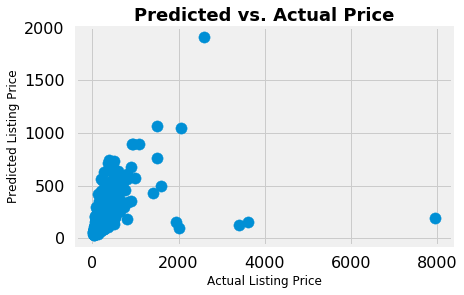

In [113]:
model = LGBMRegressor()
trained_model = train_and_test(transformed_df, model)

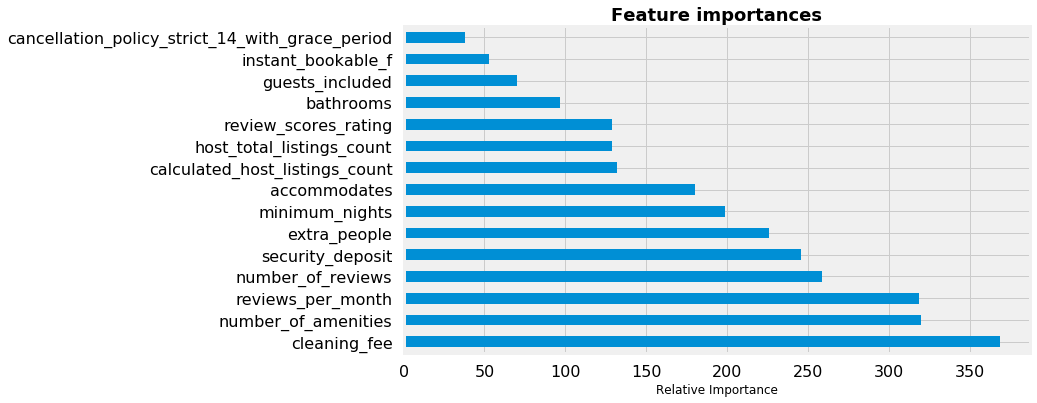

In [114]:
feat_imp = pd.Series(trained_model.feature_importances_,
                     index=transformed_df.columns.drop('price'))
feat_imp.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Relative Importance')
plt.title("Feature importances", fontsize=18, fontweight='bold')
plt.show()